# **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##**GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

# **Install**

In [ ]:
!pip install torchmetrics

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\pip\_vendor\resolvelib\resolvers.py"

# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

# **LSTM from Scratch 🧿**

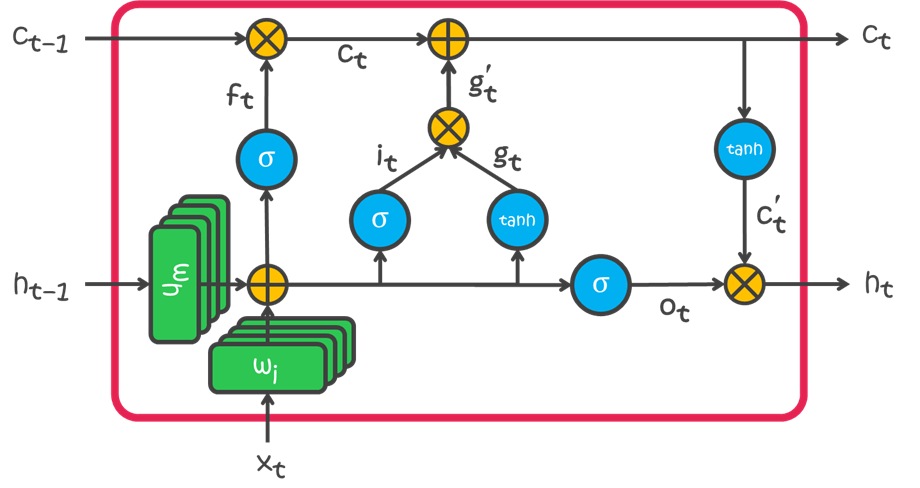

In [ ]:
class Gate(nn.Module):

  def __init__(self, hidden_size, af):
    super().__init__()
    self.fch = nn.LazyLinear(hidden_size)
    self.fcx = nn.LazyLinear(hidden_size)
    self.af = nn.Sigmoid() if af == 'sigmoid' else nn.Tanh()

  def forward(self, x, h):
    return self.af(self.fcx(x) + self.fch(h))

In [ ]:
mygate = Gate(32, 'tanh')
mygate

In [ ]:
mygate(torch.randn(3, 32), torch.randn(3, 24)).shape

In [ ]:
class LSTM(nn.Module):

  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.forget_gate = Gate(hidden_size, 'sigmoid')
    self.input_gate = Gate(hidden_size, 'sigmoid')
    self.output_gate = Gate(hidden_size, 'sigmoid')
    self.gate = Gate(hidden_size, 'tanh')

  def forward(self, x):
    ht = torch.zeros(self.hidden_size)
    ct = torch.zeros(self.hidden_size)
    output = []
    #
    for t in range(L): #BSxLxF
      xt = x[:, t, F]
      ft = self.forget_gate(xt, ht)
      ct = ct * ft
      #
      gt = self.gate(xt, ht)
      it = self.input_gate(xt, ht)
      ct = ct + gt * it
      #
      ot = self.output_gate(xt, ht)
      ht = ot * torch.tanh(ct)
      output.append(ht)
    return output, ht, ct

In [ ]:
lstm = LSTM(32)
lstm

In [ ]:
output, ht, ct = lstm(torch.randn(5, 10))

In [ ]:
len(output)

In [ ]:
output[0].shape

# **Dataset 🗂️**

## Load dataset

In [ ]:
import os
os.listdir('./deep-learning-2022-howsam/UCI HAR Dataset/train/Inertial Signals')

['body_acc_x_train.txt',
 'body_acc_y_train.txt',
 'body_acc_z_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_y_train.txt',
 'body_gyro_z_train.txt',
 'total_acc_x_train.txt',
 'total_acc_y_train.txt',
 'total_acc_z_train.txt']

In [ ]:
train_data = []
for file in glob.glob('./deep-learning-2022-howsam/UCI HAR Dataset/train/Inertial Signals/*'):
  train_data.append(np.loadtxt(file))

In [ ]:
torch.tensor(train_data).permute(1, 2, 0).shape

C:\Users\PC\AppData\Local\Temp\ipykernel_7700\1181097041.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  torch.tensor(train_data).permute(1, 2, 0).shape


torch.Size([7352, 128, 9])

In [ ]:
def har_dataset(phase):
  x = []
  data_dir = f'./deep-learning-2022-howsam/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob.glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'./deep-learning-2022-howsam/UCI HAR Dataset/{phase}/y_{phase}.txt')
  #
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [ ]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [ ]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [ ]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [ ]:
y_train

tensor([4, 4, 4,  ..., 1, 1, 1])

In [ ]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [ ]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

## DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([256, 128, 9])
torch.Size([256])


## Visulaize

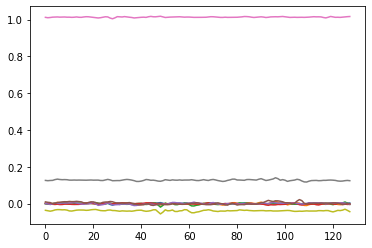

In [ ]:
plt.plot(x[0])

# **Model 🧠**

## RNN

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, RNN, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True)
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    y = self.fc(outputs) # out: many[:, -1, :]
    y = y.mean(dim=1)
    return y

In [ ]:
model = RNNModel(nn.LSTM, 9, 32, 1, False, 6)
model

RNNModel(
  (rnn): LSTM(9, 32, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [ ]:
x.shape

torch.Size([256, 128, 9])

In [ ]:
model(x).shape

torch.Size([256, 6])

## CNN

In [ ]:
conv1 = nn.Conv1d(9, 32, 3)
conv1.weight.shape

torch.Size([32, 9, 3])

In [ ]:
x.shape

torch.Size([256, 128, 9])

In [ ]:
conv1(x.permute(0, 2, 1)).shape

torch.Size([256, 32, 126])

In [ ]:
class CNNModel(nn.Module):

  def __init__(self, num_filters, kernel_size, num_cls):
    super().__init__()

    self.conv1 = nn.LazyConv1d(num_filters[0], kernel_size[0], padding=1)
    self.bn1 = nn.BatchNorm1d(num_filters[0])

    self.conv2 = nn.LazyConv1d(num_filters[1], kernel_size[1], padding=1)
    self.bn2 = nn.BatchNorm1d(num_filters[1])

    self.pool = nn.MaxPool1d(2, 2)

    self.fc = nn.LazyLinear(num_cls)


  def forward(self, x):
    x = x.permute(0, 2, 1)
    #
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    #
    y = self.pool(y)
    y = y.flatten(1)
    return self.fc(y)

In [ ]:
model = CNNModel([64, 64], [3, 3], 6)
model

C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNNModel(
  (conv1): LazyConv1d(0, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): LazyConv1d(0, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [ ]:
model(x).shape

torch.Size([256, 6])

In [ ]:
64*64*6

24576

## CNN-LSTM

In [ ]:
class CNNLSTM(nn.Module):
  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, num_cls):
    super().__init__()

    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)

    self.conv2 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn2 = nn.BatchNorm1d(cnn_hidden_size)

    self.pool = nn.MaxPool1d(2, 2)

    self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers, batch_first=True)

    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    # y = self.pool(y)

    y = y.permute(0, 2, 1)
    y, _ = self.lstm(y)
    y = self.fc(y)
    return y.mean(dim=1)

In [ ]:
model = CNNLSTM(9, 32, 128, 3, 6)
model

C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNNLSTM(
  (conv1): Conv1d(9, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(32, 128, num_layers=3)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [ ]:
y = model(x)
y.shape

torch.Size([256, 6])

## Params

In [ ]:
def num_params(model, k=1e6):
  nums = sum(p.numel() for p in model.parameters())/k
  return nums

In [ ]:
num_params(model, 1e3)

5.702

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
model = RNNModel(9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(1.7841, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = RNNModel(9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01]:
  print(f'LR={lr}')
  model = RNNModel(nn.LSTM, 9, 128, 3, False, 6).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 4: 100%|████████████████████████████████████████████| 29/29 [00:01<00:00, 27.49batch/s, accuracy=46.2, loss=1.34]



LR=0.5


Epoch 4: 100%|████████████████████████████████████████████| 29/29 [00:01<00:00, 21.81batch/s, accuracy=40.9, loss=1.42]



LR=0.2


Epoch 4: 100%|█████████████████████████████████████████████| 29/29 [00:01<00:00, 27.83batch/s, accuracy=56, loss=0.994]



LR=0.1


Epoch 4: 100%|█████████████████████████████████████████████| 29/29 [00:00<00:00, 29.71batch/s, accuracy=44.2, loss=1.2]



LR=0.01


Epoch 4: 100%|████████████████████████████████████████████| 29/29 [00:01<00:00, 28.16batch/s, accuracy=19.1, loss=1.78]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = RNNModel(9, 128, 1, True, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

## Step 5: train more epochs

In [ ]:
model = RNNModel(nn.LSTM, 9, 128, 3, False, 6).to(device)

In [ ]:
model = CNNModel([32, 32], [5, 5], 6).to(device)

C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
model = CNNLSTM(9, 32, 128, 3, 6).to(device)

In [ ]:
lr = 0.02
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, 'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

Epoch 0: 100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 21.78batch/s, accuracy=95.8, loss=0.103]


Valid: Loss = 0.3397, Acc = 0.9026



Epoch 1: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 28.57batch/s, accuracy=95.9, loss=0.0986]


Valid: Loss = 0.3352, Acc = 0.8996



Epoch 2: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 28.29batch/s, accuracy=95.9, loss=0.0969]


Valid: Loss = 0.3288, Acc = 0.8999



Epoch 3: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 29.00batch/s, accuracy=95.8, loss=0.0952]


Valid: Loss = 0.3279, Acc = 0.9009



Epoch 4: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 28.18batch/s, accuracy=95.8, loss=0.0946]


Valid: Loss = 0.3202, Acc = 0.9019



Epoch 5: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 28.27batch/s, accuracy=95.7, loss=0.0939]


Valid: Loss = 0.3161, Acc = 0.904



Epoch 6: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 29.56batch/s, accuracy=95.8, loss=0.0929]


Valid: Loss = 0.3154, Acc = 0.9057



Epoch 7: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 27.26batch/s, accuracy=95.7, loss=0.0928]


Valid: Loss = 0.319, Acc = 0.904



Epoch 8: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 28.21batch/s, accuracy=95.8, loss=0.0922]


Valid: Loss = 0.3142, Acc = 0.9019



Epoch 9: 100%|██████████████████████████████████████████| 29/29 [00:01<00:00, 28.27batch/s, accuracy=95.8, loss=0.0919]


Valid: Loss = 0.3101, Acc = 0.9046



Epoch 10: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 29.68batch/s, accuracy=95.8, loss=0.0906]


Valid: Loss = 0.3087, Acc = 0.903



Epoch 11: 100%|█████████████████████████████████████████| 29/29 [00:01<00:00, 27.86batch/s, accuracy=95.8, loss=0.0908]


Valid: Loss = 0.3079, Acc = 0.9033



Epoch 12: 100%|█████████████████████████████████████████| 29/29 [00:01<00:00, 28.24batch/s, accuracy=95.9, loss=0.0902]


Valid: Loss = 0.2996, Acc = 0.9077



Epoch 13: 100%|█████████████████████████████████████████| 29/29 [00:01<00:00, 28.77batch/s, accuracy=95.8, loss=0.0901]


Valid: Loss = 0.2968, Acc = 0.908



Epoch 14: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 33.03batch/s, accuracy=95.8, loss=0.0886]


Valid: Loss = 0.3018, Acc = 0.9043



Epoch 15: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.80batch/s, accuracy=95.8, loss=0.0886]


Valid: Loss = 0.2968, Acc = 0.9087



Epoch 16: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.65batch/s, accuracy=95.8, loss=0.0885]


Valid: Loss = 0.2992, Acc = 0.908



Epoch 17: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.54batch/s, accuracy=95.9, loss=0.0865]


Valid: Loss = 0.3046, Acc = 0.9016



Epoch 18: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.69batch/s, accuracy=95.9, loss=0.0856]


Valid: Loss = 0.2967, Acc = 0.9084



Epoch 19: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 32.33batch/s, accuracy=96, loss=0.0836]


Valid: Loss = 0.29, Acc = 0.9135



Epoch 20: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 33.10batch/s, accuracy=96, loss=0.0818]


Valid: Loss = 0.2949, Acc = 0.9094



Epoch 21: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 31.80batch/s, accuracy=96.1, loss=0.0806]


Valid: Loss = 0.2942, Acc = 0.9104



Epoch 22: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 32.40batch/s, accuracy=96, loss=0.0856]


Valid: Loss = 0.2681, Acc = 0.9108



Epoch 23: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.69batch/s, accuracy=95.6, loss=0.0953]


Valid: Loss = 0.2855, Acc = 0.9023



Epoch 24: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 33.06batch/s, accuracy=95.9, loss=0.0872]


Valid: Loss = 0.2855, Acc = 0.9074



Epoch 25: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 31.94batch/s, accuracy=96.2, loss=0.0839]


Valid: Loss = 0.2852, Acc = 0.9121



Epoch 26: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 31.94batch/s, accuracy=95.9, loss=0.0835]


Valid: Loss = 0.3064, Acc = 0.9125



Epoch 27: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.58batch/s, accuracy=96.2, loss=0.0814]


Valid: Loss = 0.2883, Acc = 0.9158



Epoch 28: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.08batch/s, accuracy=96.2, loss=0.0806]


Valid: Loss = 0.299, Acc = 0.9101



Epoch 29: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.18batch/s, accuracy=96.3, loss=0.078]


Valid: Loss = 0.2917, Acc = 0.9145



Epoch 30: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.91batch/s, accuracy=96.4, loss=0.0769]


Valid: Loss = 0.3011, Acc = 0.9141



Epoch 31: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.18batch/s, accuracy=96.4, loss=0.0752]


Valid: Loss = 0.3086, Acc = 0.9125



Epoch 32: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.73batch/s, accuracy=96.3, loss=0.074]


Valid: Loss = 0.305, Acc = 0.9118



Epoch 33: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.40batch/s, accuracy=95.8, loss=0.101]


Valid: Loss = 0.2693, Acc = 0.9057



Epoch 34: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.84batch/s, accuracy=95.3, loss=0.103]


Valid: Loss = 0.2694, Acc = 0.9094



Epoch 35: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 31.62batch/s, accuracy=96, loss=0.0934]


Valid: Loss = 0.2754, Acc = 0.9135



Epoch 36: 100%|████████████████████████████████████████████| 29/29 [00:00<00:00, 32.62batch/s, accuracy=96, loss=0.093]


Valid: Loss = 0.2616, Acc = 0.9213



Epoch 37: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.62batch/s, accuracy=95.9, loss=0.094]


Valid: Loss = 0.2841, Acc = 0.9074



Epoch 38: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 32.54batch/s, accuracy=96, loss=0.0935]


Valid: Loss = 0.3028, Acc = 0.9013



Epoch 39: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.58batch/s, accuracy=96.1, loss=0.0905]


Valid: Loss = 0.2852, Acc = 0.9104



Epoch 40: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.22batch/s, accuracy=95.8, loss=0.0959]


Valid: Loss = 0.2866, Acc = 0.8996



Epoch 41: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.44batch/s, accuracy=95.8, loss=0.0952]


Valid: Loss = 0.2646, Acc = 0.9206



Epoch 42: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.73batch/s, accuracy=96.3, loss=0.0889]


Valid: Loss = 0.2777, Acc = 0.9111



Epoch 43: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.84batch/s, accuracy=96.2, loss=0.0876]


Valid: Loss = 0.2743, Acc = 0.9165



Epoch 44: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.88batch/s, accuracy=96.3, loss=0.0856]


Valid: Loss = 0.2722, Acc = 0.9152



Epoch 45: 100%|█████████████████████████████████████████| 29/29 [00:01<00:00, 26.29batch/s, accuracy=96.5, loss=0.0831]


Valid: Loss = 0.2981, Acc = 0.9057



Epoch 46: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.95batch/s, accuracy=96.2, loss=0.0864]


Valid: Loss = 0.2835, Acc = 0.9128



Epoch 47: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.88batch/s, accuracy=96.6, loss=0.0815]


Valid: Loss = 0.2826, Acc = 0.9209



Epoch 48: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 33.10batch/s, accuracy=96.4, loss=0.0844]


Valid: Loss = 0.2955, Acc = 0.9128



Epoch 49: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 32.95batch/s, accuracy=96, loss=0.0884]


Valid: Loss = 0.2761, Acc = 0.9199



Epoch 50: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.76batch/s, accuracy=96.4, loss=0.0825]


Valid: Loss = 0.2898, Acc = 0.9125



Epoch 51: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.54batch/s, accuracy=96.1, loss=0.0879]


Valid: Loss = 0.2729, Acc = 0.9145



Epoch 52: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.95batch/s, accuracy=96.6, loss=0.0797]


Valid: Loss = 0.2934, Acc = 0.9101



Epoch 53: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.08batch/s, accuracy=96.4, loss=0.0808]


Valid: Loss = 0.2902, Acc = 0.9148



Epoch 54: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.36batch/s, accuracy=96.6, loss=0.0799]


Valid: Loss = 0.2867, Acc = 0.9148



Epoch 55: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.54batch/s, accuracy=96.5, loss=0.082]


Valid: Loss = 0.2932, Acc = 0.9128



Epoch 56: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.80batch/s, accuracy=96.7, loss=0.0797]


Valid: Loss = 0.2961, Acc = 0.906



Epoch 57: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.18batch/s, accuracy=96.7, loss=0.0772]


Valid: Loss = 0.2886, Acc = 0.9175



Epoch 58: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.99batch/s, accuracy=96.7, loss=0.0776]


Valid: Loss = 0.3269, Acc = 0.9053



Epoch 59: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.44batch/s, accuracy=96.7, loss=0.0754]


Valid: Loss = 0.3172, Acc = 0.9097



Epoch 60: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 30.82batch/s, accuracy=96.5, loss=0.0783]


Valid: Loss = 0.3084, Acc = 0.9121



Epoch 61: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.51batch/s, accuracy=96.5, loss=0.0776]


Valid: Loss = 0.3134, Acc = 0.9053



Epoch 62: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.58batch/s, accuracy=96.4, loss=0.078]


Valid: Loss = 0.3214, Acc = 0.9084



Epoch 63: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.65batch/s, accuracy=96.6, loss=0.0768]


Valid: Loss = 0.3284, Acc = 0.8982



Epoch 64: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.95batch/s, accuracy=96.2, loss=0.0831]


Valid: Loss = 0.3168, Acc = 0.907



Epoch 65: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.51batch/s, accuracy=95.4, loss=0.111]


Valid: Loss = 0.3493, Acc = 0.8962



Epoch 66: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.22batch/s, accuracy=95.4, loss=0.105]


Valid: Loss = 0.3241, Acc = 0.9155



Epoch 67: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.69batch/s, accuracy=95.4, loss=0.102]


Valid: Loss = 0.286, Acc = 0.9121



Epoch 68: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.65batch/s, accuracy=95.5, loss=0.0945]


Valid: Loss = 0.259, Acc = 0.9189



Epoch 69: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.40batch/s, accuracy=95.4, loss=0.106]


Valid: Loss = 0.2719, Acc = 0.9165



Epoch 70: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.69batch/s, accuracy=95.5, loss=0.0944]


Valid: Loss = 0.2811, Acc = 0.9223



Epoch 71: 100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 33.21batch/s, accuracy=96, loss=0.0869]


Valid: Loss = 0.2924, Acc = 0.9192



Epoch 72: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.47batch/s, accuracy=94.8, loss=0.123]


Valid: Loss = 0.2756, Acc = 0.8941



Epoch 73: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.22batch/s, accuracy=94.5, loss=0.108]


Valid: Loss = 0.2502, Acc = 0.9097



Epoch 74: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.73batch/s, accuracy=95.6, loss=0.0915]


Valid: Loss = 0.2534, Acc = 0.9074



Epoch 75: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.11batch/s, accuracy=95.7, loss=0.0847]


Valid: Loss = 0.2603, Acc = 0.9148



Epoch 76: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.54batch/s, accuracy=96.1, loss=0.0796]


Valid: Loss = 0.2658, Acc = 0.9186



Epoch 77: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.69batch/s, accuracy=96.5, loss=0.0781]


Valid: Loss = 0.3143, Acc = 0.9233



Epoch 78: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 32.51batch/s, accuracy=96.3, loss=0.0818]


Valid: Loss = 0.3003, Acc = 0.9158



Epoch 79: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 32.91batch/s, accuracy=95.6, loss=0.101]


Valid: Loss = 0.2372, Acc = 0.9067



# **Plot**

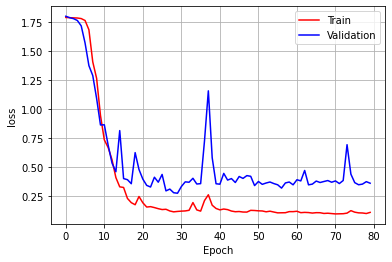

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

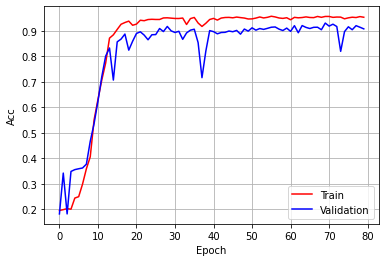

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# **Runtime ⏲**